## **Classify Song Genres**

Streaming services categorize music to allow for personalized recommendations. They directly analyze the raw audio information and score the raw data on a variety of metrics. 

With this project, I'll analyze data compiled by a music intelligence and data platform known as 'The Echo Nest.' The goal of the project is to look deep through the dataset and classify the 'genres' of the songs and that too without listening to a single song.

Let's start by loading the libraries required for this project.

In [111]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from pandas import set_option

# Sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split

# Sklearn classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Plotting tools
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Prepare the dataset

In [112]:
# Read in track metadata with genre labels
tracks = pd.read_csv('./datasets/fma-rock-vs-hiphop.csv')
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [113]:
# Read in track metrics with the features
metrics = pd.read_json('datasets/echonest-metrics.json', precise_float=True)
metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [114]:
# Merge the relevant columns of tracks and metrics datasets
df = pd.merge(metrics, tracks[['track_id', 'genre_top']], on='track_id')
df = df.drop('track_id', axis=1)
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [115]:
# Inspect the merged dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      4802 non-null   float64
 1   danceability      4802 non-null   float64
 2   energy            4802 non-null   float64
 3   instrumentalness  4802 non-null   float64
 4   liveness          4802 non-null   float64
 5   speechiness       4802 non-null   float64
 6   tempo             4802 non-null   float64
 7   valence           4802 non-null   float64
 8   genre_top         4802 non-null   object 
dtypes: float64(8), object(1)
memory usage: 375.2+ KB


We have 4,802 instances to work with and no missing values. We can also confirm that the data has only 1 categorical feature, the target attribute.

In [116]:
# Descriptions
df.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,4.802000e+03,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000
mean,4.870600e-01,0.436556,0.625126,0.604096,0.187997,0.104877,126.687944,0.453413
std,3.681396e-01,0.183502,0.244051,0.376487,0.150562,0.145934,34.002473,0.266632
min,9.491000e-07,0.051307,0.000279,0.000000,0.025297,0.023234,29.093000,0.014392
25%,8.351236e-02,0.296047,0.450757,0.164972,0.104052,0.036897,98.000750,0.224617
50%,5.156888e-01,0.419447,0.648374,0.808752,0.123080,0.049594,124.625500,0.446240
75%,8.555765e-01,0.565339,0.837016,0.915472,0.215151,0.088290,151.450000,0.666914
max,9.957965e-01,0.961871,0.999768,0.993134,0.971392,0.966177,250.059000,0.983649


## Visualize individual attributes

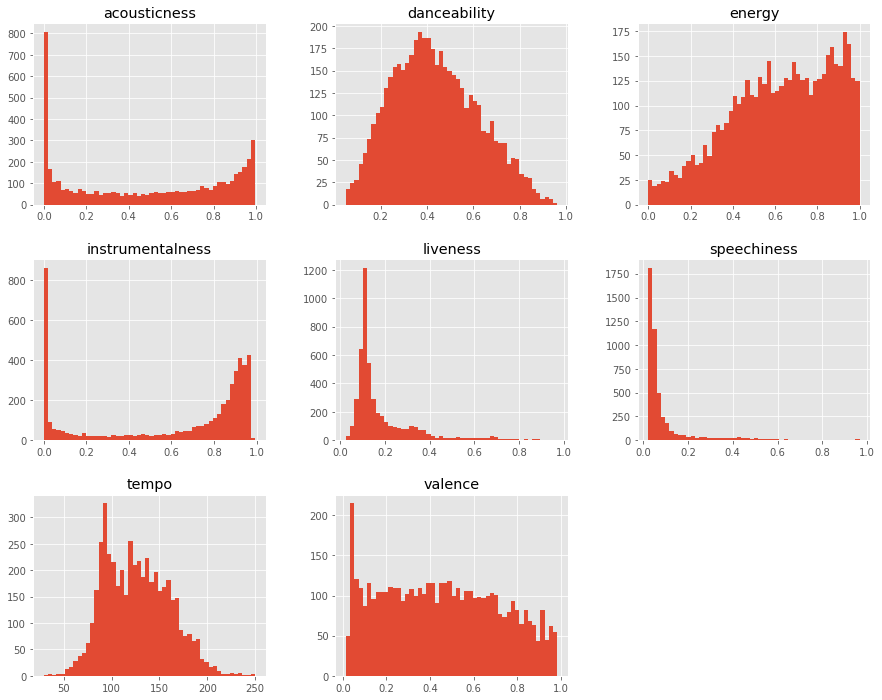

In [117]:
# Histograms
df.hist(bins=50, figsize=(15,12));

We can see that there are only a cuple of normal-like distributions.

## Box and whisker plots to get an idea of the spread of values

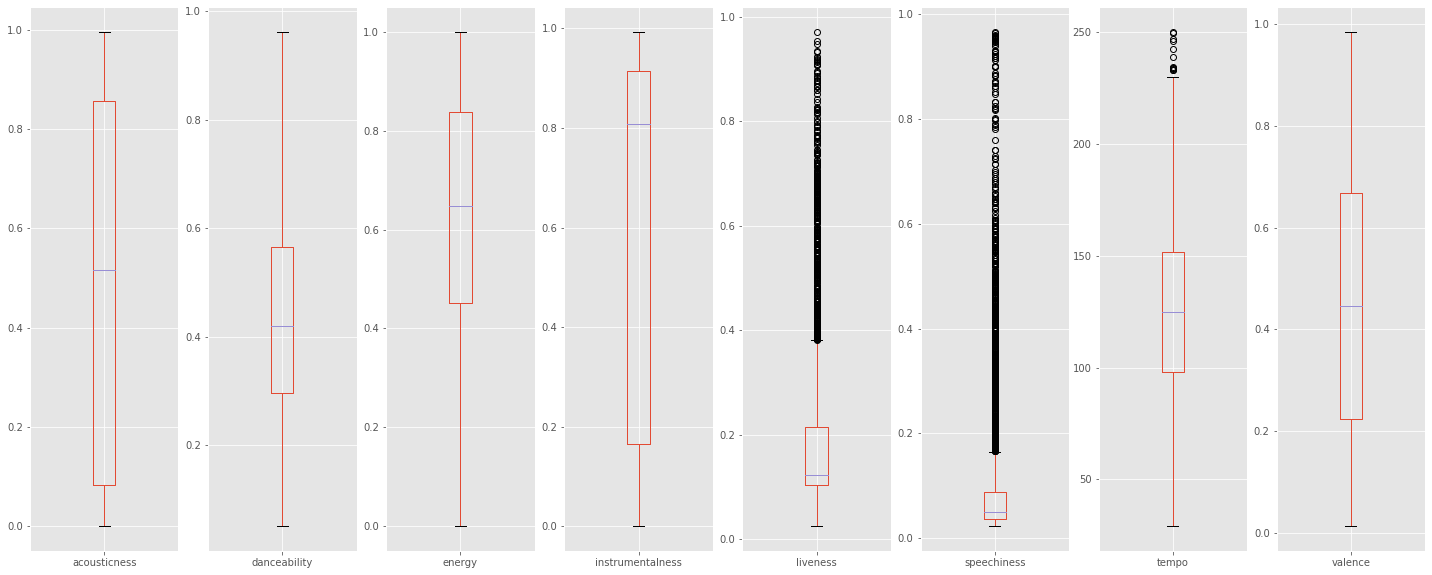

In [118]:
# Box and whisker plots
df.plot(kind='box', subplots=True)
plt.gcf().set_size_inches(25,10);

The attributes have different spreads, with a couple of variables having outliers. We need to standardize the data to get all the means lined up and use winsorize to handle the outliers for modeling.

## Let's winsorize outliers

In [119]:
# Winsorize outliers
from scipy.stats.mstats import winsorize

# Winsorize the columns with outliers
win = winsorize(df[['liveness', 'speechiness', 'tempo']], limits=[0.05, 0.05])

# Convert to datafraame
df_win = pd.DataFrame(win, columns=['liveness', 'speechiness', 'tempo'])

df_non_win = df.drop(['liveness', 'speechiness', 'tempo'], axis=1)

df = pd.concat([df_win, df_non_win], axis=1)
df.describe()

,liveness,speechiness,tempo,acousticness,danceability,energy,instrumentalness,valence
count,4802.000000,4802.000000,4802.000000,4.802000e+03,4802.000000,4802.000000,4802.000000,4802.000000
mean,0.188005,0.105319,124.017036,4.870600e-01,0.436556,0.625126,0.604096,0.453413
std,0.150554,0.145709,29.431442,3.681396e-01,0.183502,0.244051,0.376487,0.266632
min,0.032849,0.032849,29.093000,9.491000e-07,0.051307,0.000279,0.000000,0.014392
25%,0.104052,0.036897,98.000750,8.351236e-02,0.296047,0.450757,0.164972,0.224617
50%,0.123080,0.049594,124.625500,5.156888e-01,0.419447,0.648374,0.808752,0.446240
75%,0.215151,0.088290,151.450000,8.555765e-01,0.565339,0.837016,0.915472,0.666914
max,0.971392,0.966177,163.994000,9.957965e-01,0.961871,0.999768,0.993134,0.983649


## Principal Component Analysis

Let's see how much we can reduce the dimensionality of our data, using PCA. We can use scree plots and cumulative explained ratio plots to find the number of components to use in further analyses.

In [120]:
# Define our features 
X = df.drop(['genre_top'], axis=1)

# Define our labels
y = df['genre_top'].map({'Rock': 1, 'Hip-Hop': 0})

In [121]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())])

In [122]:
# Fit the pipe to the data
pc = pipe.fit_transform(X)
var = pipe.steps[1][1].explained_variance_ratio_

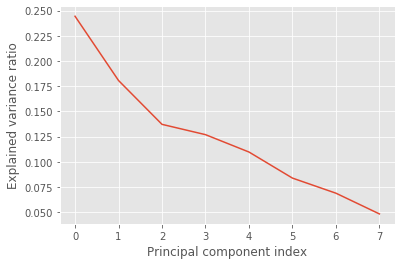

In [123]:
# Scree plots
pipe.fit(X)
plt.plot(var)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

## Further visualization of PCA

It seems there isn't any clear elbow in this scree plot. Let's take a look at the cumulative explained variance plot to determine how many features are required to explain, say, about 90% of the variance. Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

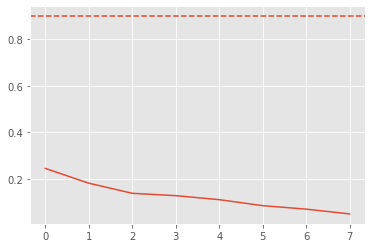

In [124]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(var)

# Plot the cumulative explained variance and draw a dashed line at 0.90
fig, ax = plt.subplots()
ax.plot(range(8), var)
ax.axhline(y=0.9, linestyle='--')
n_components=2

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(X)
pca_projection = pca.transform(X)

## Build the model

In [125]:
# Split our data
X_train, X_test, y_train, y_test = train_test_split(pca_projection, y, test_size=0.20, random_state=42)

In [126]:
# Define a list called classifier that contains the tuples (classifier name, classifier)
classifiers = [('logreg', LogisticRegression()),
('knn', KNeighborsClassifier()),
('rf', RandomForestClassifier()),
('svm', SVC())]

## Evaluate algorithms: baseline

The algorithms all use default tuning parameters. We will display the mean and standard deviation of accuracy for each algorithm as we calculate it and collect the results for use later.

In [127]:
results = []
names = []
for name, model in classifiers:
    kfold = KFold(n_splits=10)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_score)
    names.append(name)
    print(f'{name}: {cv_score.mean()}, {cv_score.std()}')

logreg: 0.8091659902597403, 0.017873560839897985
knn: 0.8182738095238096, 0.017134730113099326
rf: 0.8341531385281385, 0.01216186605828859
svm: 0.8104646915584416, 0.020805556096475056


The results suggest that Random Forest is way ahead of other classifiers.

## Compare the algorithms

These are just mean accuracy values. Let's take a look at the distribution of accuracy values across different cross-validation folds, using box and whisker plots.

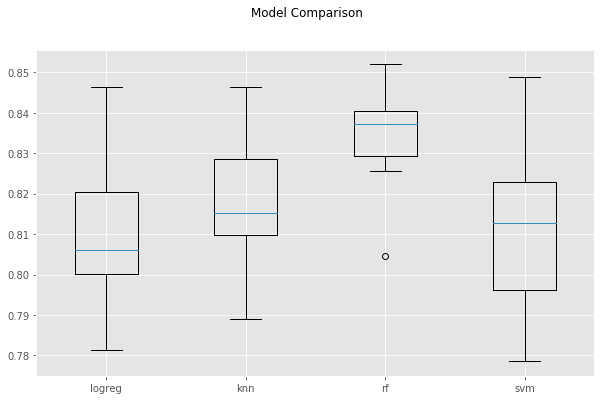

In [128]:
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.gcf().set_size_inches(10,6)

The results show a tight distribution for Random Forest, suggesting low variance.

## Tuning Random Forest

We can tune a couple of key parameters of the Random Forest algorithm. We will perform a grid search using 10-fold cross validation.

In [129]:
# Define the parameters
param_grid = {'n_estimators': [100,350,500],
'max_features': ['log2', 'auto', 'sqrt'],
'min_samples_leaf': [2,10,30]
}

In [130]:
# Tune random forest classifier
kfold = KFold(n_splits=10)
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring = 'accuracy', cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.849512 using {'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 500}
0.837539 (0.012590) with: {'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 100}
0.842223 (0.012011) with: {'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 350}
0.844307 (0.011455) with: {'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 500}
0.848732 (0.014139) with: {'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 100}
0.847168 (0.016196) with: {'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 350}
0.847952 (0.013784) with: {'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 500}
0.847432 (0.016052) with: {'max_features': 'log2', 'min_samples_leaf': 30, 'n_estimators': 100}
0.845610 (0.015480) with: {'max_features': 'log2', 'min_samples_leaf': 30, 'n_estimators': 350}
0.846130 (0.017286) with: {'max_features': 'log2', 'min_samples_leaf': 30, 'n_estimators': 500}
0.844046 (0.009347) with: {'max_features': 'auto

We can see the best conguration for Random Forest algorithm was with 500 trees, 'auto' max_features and 10 min_samples_leaf. The accuracy 84.95% is seemingly better too.

## Finalize the model

Random Forest showed the most promise for this problem. We will now finalize the model by training it on the entire training dataset and make predictions for the hold-out validation dataset to confirm our findings.

In [131]:
# Find the best paramaters
grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [134]:
# Estimate accuracy on validation dataset
model = RandomForestClassifier(max_features='auto',
                              min_samples_leaf=10,
                              n_estimators=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8459937565036421
[[ 79 103]
 [ 45 734]]


We can see that we have achieved an accuracy of 84.59% on the held-out validation dataset. This score matches very closely to our expectations estimated above during the tuning of Random Forest.

## Write out pickel model

In [133]:
joblib.dump(grid.best_estimator_, 'Pickle/classify_song.pkl')

['Pickle/classify_song.pkl']